In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm

from sklearn.decomposition import PCA
import umap
import random

import sys
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre

import matplotlib.pyplot as plt
import json

from probeinterface import write_prb, read_prb

import torch.nn.functional as F
from pathlib import Path

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [2]:
channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]}

channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }

In [7]:
def count_array2_in_range_of_array1(array1, array2, threshold=5):

    sorted_array1 = np.sort(array1)
    
    lefts = array2 - threshold
    rights = array2 + threshold
    
    left_indices = np.searchsorted(sorted_array1, lefts, side='left')
    
    right_indices = np.searchsorted(sorted_array1, rights, side='right')
    
    has_within_range = right_indices > left_indices
    
    count = np.sum(has_within_range)
    
    return count


def detect_local_maxima_in_window(data, window_size=20, std_multiplier=2):

    """
    在每个滑动窗口范围内检测局部最大值的索引，并确保最大值大于两倍的标准差。

    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_rows, n_columns)。
    window_size : int
        滑动窗口的大小，用于定义局部范围，默认为 20。
    std_multiplier : float
        标准差的倍数，用于筛选局部最大值，默认为 2。

    返回:
    local_maxima_indices : list of numpy.ndarray
        每行局部最大值的索引列表，每个元素是对应行局部最大值的索引数组。
    """
    local_maxima_indices = []

    for row in data:
        maxima_indices = []
        row_std = np.std(row)
        threshold = std_multiplier * row_std

        for start in range(0, len(row), window_size):
            end = min(start + window_size, len(row))
            window = row[start:end]
            
            if len(window) > 0:
                local_max_index = np.argmax(window)
                local_max_value = window[local_max_index]
                
                if local_max_value > threshold:
                    maxima_indices.append(start + local_max_index)  
        
        local_maxima_indices.extend(maxima_indices)
        local_maxima_indices = list(set(local_maxima_indices))  

    return local_maxima_indices


def cluster_label_array1_based_on_array2(array1, array2, threshold=5, 
                                         cluster_column='cluster'):

    """
    根据 array2 的 'time' 和 'cluster' 对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 的 'time' 中，则标记为对应的 'cluster' 值，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        包含 'time' 和 'cluster' 的二维数组。
        第一列为 'time'，第二列为 'cluster'。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 array2 中的 'cluster' 或 0。
    """

    array2 = np.array((array2['time'], array2[cluster_column])).T
    sorted_indices = np.argsort(array2[:, 0])
    sorted_array2 = array2[sorted_indices]
    
    labels = -np.ones(len(array1), dtype=int)
    
    # 遍历 array1 中的每个元素
    for i, value in enumerate(array1):
        # 计算当前值的范围
        left = value - threshold
        right = value + threshold
        
        left_index = np.searchsorted(sorted_array2[:, 0], left, side='left')
        right_index = np.searchsorted(sorted_array2[:, 0], right, side='right')
        
        # 如果范围内存在值，则标记为对应的 'cluster'
        if right_index > left_index:
            # 获取范围内的第一个匹配值的 'cluster'
            labels[i] = sorted_array2[left_index, 1]
    
    return labels


def label_array1_based_on_array2(array1, array2, threshold=5):

    """
    根据 array2 的值对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 中，则标记为 1，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        用于判断的数组。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 0 或 1。
    """
    # 对 array2 进行排序以加速搜索
    sorted_array2 = np.sort(array2)
    
    # 初始化标签数组，默认值为 0
    labels = np.zeros(len(array1), dtype=int)
    
    # 遍历 array1 中的每个元素
    for i, value in enumerate(array1):
        # 计算当前值的范围
        left = value - threshold
        right = value + threshold
        
        # 使用二分搜索判断范围内是否存在值
        left_index = np.searchsorted(sorted_array2, left, side='left')
        right_index = np.searchsorted(sorted_array2, right, side='right')
        
        # 如果范围内存在值，则标记为 1
        if right_index > left_index:
            labels[i] = 1
    
    return labels


def extract_windows(data, indices, window_size=61):
    """
    根据给定的时间点索引提取窗口。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    indices : numpy.ndarray
        时间点索引数组，用于指定需要提取窗口的中心点
    window_size : int
        窗口长度，默认为61（对应time-30到time+31）
    
    返回:
    windows : numpy.ndarray
        提取的窗口数据，形状为 (len(indices), n_channels, window_size)
    """
    n_channels, time_length = data.shape
    half_window = window_size // 2

    if np.any(indices < half_window) or np.any(indices >= time_length - half_window):
        raise ValueError("Some indices are out of bounds for the given window size.")

    windows = []
    for idx in indices:
        window = data[:, idx - half_window:idx + half_window + 1]
        windows.append(window)

    windows = np.array(windows)
    return windows
def calculate_position(row):
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]
    waveform = row['waveform'] 
    
    a_squared = [np.sum(waveform[:, j]**2) for j in range(len(channels))]
    
    sum_x_a = 0
    sum_y_a = 0
    sum_a = 0
    
    for j, channel in enumerate(channels):
        x_i, y_i = channel_position.get(channel, [0, 0])  
        a_i_sq = a_squared[j]
        
        sum_x_a += x_i * a_i_sq
        sum_y_a += y_i * a_i_sq
        sum_a += a_i_sq
    
    if sum_a == 0:
        return pd.Series({'position_1': 0, 'position_2': 0})
    
    x_hat = sum_x_a / sum_a
    y_hat = sum_y_a / sum_a
    return pd.Series({'position_1': x_hat, 'position_2': y_hat})

def calculate_position_waveform(row, channel_position, channel_indices, power=2):
    x_target = row['position_1']
    y_target = row['position_2']
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]  
    waveforms = row['waveform']  
    
    distances = []
    for channel in channels:
        x_channel, y_channel = channel_position.get(channel, [np.nan, np.nan])
        if np.isnan(x_channel):  
            continue
        distance = np.sqrt((x_target - x_channel)**2 + (y_target - y_channel)**2)
        distances.append(distance)
    
    if not distances:  
        return np.zeros(31)
    
    #IDW
    weights = 1 / (np.array(distances) ** power)
    if np.any(distances == 0):
        zero_idx = np.argwhere(distances == 0).flatten()
        return waveforms[:, zero_idx[0]]
    
    weights /= np.sum(weights)
    
    synthesized_waveform = np.zeros(31)
    for t in range(31): 
        weighted_sum = np.dot(waveforms[t, :], weights)
        synthesized_waveform[t] = weighted_sum
    
    return synthesized_waveform


def compute_cluster_average(sample_data, potent_spike_inf, cluster_column='cluster_predicted'):
    """
    计算 potent_spike_inf 中每个 cluster_predicted 对应的 sample_data 的平均值。
    
    参数:
    - sample_data: np.ndarray, 输入的 (n, 30, 61) 矩阵。
    - potent_spike_inf: pd.DataFrame, 包含 cluster_predicted 信息的 DataFrame。
    - cluster_column: str, cluster 信息所在的列名。
    
    返回:
    - cluster_averages: dict, 每个 cluster 对应的平均值矩阵 (30, 61)。
    """
    cluster_averages = {}
    unique_clusters = potent_spike_inf[cluster_column].unique()
    
    for cluster in unique_clusters:
        cluster_indices = potent_spike_inf[potent_spike_inf[cluster_column] == cluster].index
        cluster_average = sample_data[cluster_indices].mean(axis=0) 
        cluster_averages[cluster] = cluster_average
    
    return cluster_averages

def judge_cluster_reality(row, neuron_inf):
    from scipy.stats import pearsonr

    position_threshold =10
    position_condition = (
        (abs(neuron_inf['position_1'] - row['position_1']) <= position_threshold) &
        (abs(neuron_inf['position_2'] - row['position_2']) <= position_threshold)
    )

    candidate_neurons = neuron_inf[position_condition]

    if candidate_neurons.empty:
        return None

    waveform_threshold = 0.95
    row_waveform = row['position_waveform']
    best_match = None
    best_corr = -1 

    for _, candidate in candidate_neurons.iterrows():
        neuron_inf_waveform = candidate['position_waveform'][15:-15]
        corr, _ = pearsonr(row_waveform, neuron_inf_waveform)

        if corr > waveform_threshold and corr > best_corr:
            best_corr = corr
            best_match = candidate['cluster']

    return best_match if best_match is not None else None


def process_cluster_averages(cluster_averages, channel_indices):
    """
    对 cluster_averages 中的每个 item，找到最大值所在的通道，
    并根据 channel_indices 保留对应的 6 个通道。
    
    参数:
    - cluster_averages: dict, 每个 cluster 的平均值 (30, 61)。
    - channel_indices: dict, 通道索引字典。
    
    返回:
    - processed_averages: dict, 处理后的字典，键为 cluster_channelindices，值为 (6, 61) 的数组。
    """
    processed_averages = {}
    
    for cluster, avg_matrix in cluster_averages.items():
        max_channel = np.argmax(avg_matrix.max(axis=1))  
        
        for key, indices in channel_indices.items():
            if max_channel in indices:
                selected_channels = avg_matrix[indices, :]
                new_key = f"{cluster}_{key}"
                processed_averages[new_key] = selected_channels
                break
    
    return processed_averages

def predict_new(feature, kmeans):
    dists = pairwise_distances(feature, kmeans.cluster_centers_ )
    return np.argmin(dists, axis=1)

## Model Train

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        return self.data[idx].astype(np.float32), self.labels[idx]

class Spike_Classification_MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Spike_Classification_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)  

    def forward(self, x):
        x = x.reshape(-1, 31 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)  
        return x

In [5]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_021322_natural_image_001.ns4')
recording_recorded = recording_raw.remove_channels(["98", '31', '32'])
recording_stimulated = recording_raw.channel_slice(['98'])

recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_f = spre.common_reference(recording_f, reference="global", operator="median")

spike_inf = pd.read_csv("/media/ubuntu/sda/Spike_Sorting/paper_architecture/01_real_data/01_flexible_probe_30_channels/kilosort_spike_sorting/sorting_results/021322/spike_inf.csv")
removed_spikes = spike_inf['cluster'].value_counts()
removed_spikes = removed_spikes[removed_spikes < 8000].index
spike_inf = spike_inf[~spike_inf['cluster'].isin(removed_spikes)]

In [8]:
total_frames = int(recording_f.get_total_duration() * 10000)
chunk_size = 100000  
window_size = 31
half_window = window_size // 2

all_valid_indices = []
all_windows = []

for start_frame in range(0, total_frames, chunk_size):
    end_frame = min(start_frame + chunk_size, total_frames)
    
    data_chunk = recording_f.get_traces(
        start_frame=start_frame,
        end_frame=end_frame
    )  
    
    threshold_result = detect_local_maxima_in_window(
        data_chunk.T,  
        std_multiplier=2
    )
    
    threshold_result = np.array(threshold_result) + start_frame
    valid_indices = threshold_result[
        (threshold_result >= start_frame + half_window + 1) & 
        (threshold_result < end_frame - half_window)
    ]
    
    for idx in valid_indices:
        rel_idx = idx - start_frame
        window = data_chunk.T[:, rel_idx-half_window : rel_idx+half_window+1]
        all_windows.append(window)
    
    all_valid_indices.extend(valid_indices)

all_valid_indices = np.array(all_valid_indices)
all_windows = np.stack(all_windows)  

cluster_labels = cluster_label_array1_based_on_array2(all_valid_indices, spike_inf, threshold=1)

valid_indices = cluster_labels != -1
all_windows = all_windows[valid_indices]
cluster_labels = cluster_labels[valid_indices]

In [9]:
potent_spike_inf = pd.DataFrame((all_valid_indices[valid_indices], cluster_labels), index= ['time', 'cluster']).T
# potent_spike_inf = potent_spike_inf[potent_spike_inf['cluster'] != -1]

unique_clusters = np.unique(potent_spike_inf['cluster'])
cluster_to_index = {cluster: idx for idx, cluster in enumerate(unique_clusters)}
potent_spike_inf['cluster_rep'] = np.array([cluster_to_index[cluster] for cluster in potent_spike_inf['cluster']])

In [10]:
indices = potent_spike_inf['time'].values

labels = potent_spike_inf['cluster_rep'].values

balanced_indices = []
for cluster in potent_spike_inf['cluster_rep'].unique():
    cluster_indices = np.where(labels == cluster)[0]
    if len(cluster_indices) > 8000:
        sampled_indices = np.random.choice(cluster_indices, 8000, replace=False)
    else:
        sampled_indices = cluster_indices
    balanced_indices.extend(sampled_indices)

np.random.shuffle(balanced_indices)

balanced_data = all_windows[balanced_indices]
balanced_labels = labels[balanced_indices]

dataset = CustomDataset(balanced_data, balanced_labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for trail in range(2, 6):
    device = 'cuda'
    input_size = balanced_data.shape[1] * balanced_data.shape[2]
    hidden_size1 = 64
    hidden_size2 = 50
    num_classes = potent_spike_inf['cluster_rep'].nunique()
    model = Spike_Classification_MLP(input_size, hidden_size1, hidden_size2, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    num_epochs = 210
    accuracy_best = 0
    i = 0
    for epoch in range(num_epochs):
        all_labels = []
        all_predictions = []
        model.train()
        total_loss = 0
        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)


            outputs = model(batch_data)
            predicted = torch.argmax(outputs, dim=1)  

            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            all_labels.extend(batch_labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        # print(f"Train Accuracy: {accuracy * 100:.2f}%")
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

        model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch_data, batch_labels in test_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_data)
                predicted = torch.argmax(outputs, dim=1)  

                all_labels.extend(batch_labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

        accuracy = accuracy_score(all_labels, all_predictions)
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            i = 0
            torch.save(model, f'/media/ubuntu/sda/Spike_Sorting/paper_architecture/01_real_data/01_flexible_probe_30_channels/spike_classification/train_results/spike_classification_model_{trail}.pth')
            print(f"Best model saved with TPR: {accuracy_best:.4f}")
            print("_" * 60)

        else:
            i += 1
            if i == 3:
                print(f"Training stopped after {epoch+1} epochs with best TPR: {accuracy_best:.4f}")
                print("_" * 60)
                break
    

Best model saved with TPR: 0.0445
____________________________________________________________
Best model saved with TPR: 0.0765
____________________________________________________________
Best model saved with TPR: 0.1129
____________________________________________________________
Best model saved with TPR: 0.1501
____________________________________________________________
Best model saved with TPR: 0.1876
____________________________________________________________
Best model saved with TPR: 0.2279
____________________________________________________________
Best model saved with TPR: 0.2687
____________________________________________________________
Best model saved with TPR: 0.3085
____________________________________________________________
Best model saved with TPR: 0.3477
____________________________________________________________
Best model saved with TPR: 0.3870
____________________________________________________________
Best model saved with TPR: 0.4240
________________

In [ ]:
# model.eval()
# true_labels = []
# embeddings = []

# with torch.no_grad():
#     for batch_data, batch_labels in test_loader:
#         batch_data = batch_data.to(device)
#         batch_labels = batch_labels.to(device)

#         #outputs = model(batch_data)
#         #predicted = torch.argmax(outputs, dim=1)  
#         x = batch_data.reshape(-1, 31 * 30)
#         x = model.fc1(x)
#         x = model.relu1(x)
#         x = model.fc2(x)

#         embeddings.append(model.relu2(x).cpu().numpy())
#         true_labels.extend(batch_labels.cpu().numpy())

# embeddings = np.vstack(embeddings)
# true_labels = np.array(true_labels)


In [ ]:
# import umap
# import matplotlib.pyplot as plt

# umap_model = umap.UMAP(n_components=2, random_state=42)
# embeddings_2d = umap_model.fit_transform(embeddings)


In [ ]:
# sample_indices = np.random.choice(embeddings_2d.shape[0], 10000, replace=False)

# sampled_embeddings_2d = embeddings_2d[sample_indices]
# sampled_true_labels = true_labels[sample_indices]

In [ ]:
# from matplotlib.colors import ListedColormap

# unique_clusters = np.unique(sampled_true_labels)
# cluster_to_str = {cluster: f"Cluster_{cluster}" for cluster in unique_clusters}
# sampled_true_labels_str = np.array([cluster_to_str[label] for label in sampled_true_labels])

# # 为每个 cluster 分配不同的颜色
# num_clusters = len(unique_clusters)
# cmap = plt.cm.get_cmap('tab20', num_clusters)  # 使用 'tab20' colormap，支持最多 20 种颜色

# # 绘制 UMAP 降维后的图
# plt.figure(figsize=(8, 8), dpi= 800)
# scatter = plt.scatter(sampled_embeddings_2d[:, 0], sampled_embeddings_2d[:, 1], 
#                       c=sampled_true_labels, cmap=cmap, alpha=1, s = 1)

# plt.grid(False)
# plt.savefig("train_test_umap.png", dpi=800, bbox_inches='tight')
# plt.close()


## Month 2 Eval

In [ ]:
with open('/media/ubuntu/sda/Spike_Sorting/paper_architecture/01_real_data/01_flexible_probe_30_channels/kilosort_spike_sorting/sorting_results/021322/neuron_inf.pkl', 'rb') as f:
    neuron_inf = pickle.load(f)

In [ ]:
model = torch.load('/media/ubuntu/sda/Spike_Sorting/paper_architecture/01_real_data/01_flexible_probe_30_channels/spike_classification/train_results/spike_classification_model_1.pth', weights_only=False)

In [ ]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_022522_natural_image_001.ns4')
recording_recorded = recording_raw.remove_channels(['98', '31', '32'])
recording_stimulated = recording_raw.channel_slice(['98'])

recording_f_22522 = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_f_22522 = spre.common_reference(recording_f_22522, reference="global", operator="median")

In [ ]:
data_22522 = recording_f_22522.get_traces().astype("float32").T

In [ ]:
threshold_result_22522 = detect_local_maxima_in_window(data_22522)
threshold_result_22522 = np.array(threshold_result_22522)
valid_indices_22522 = threshold_result_22522[(threshold_result_22522 > 30)]
valid_indices_22522 = valid_indices_22522[valid_indices_22522 < data_22522.shape[1] - 31]

In [ ]:
spike_inf_22522 = pd.read_csv("/media/ubuntu/sda/Spike_Sorting/paper_architecture/01_real_data/01_flexible_probe_30_channels/kilosort_spike_sorting/sorting_results/022522/spike_inf.csv")

removed_spikes = spike_inf_22522['cluster'].value_counts()
removed_spikes = removed_spikes[removed_spikes < 8000].index
spike_inf_22522 = spike_inf_22522[~spike_inf_22522['cluster'].isin(removed_spikes)]
spike_inf_22522 = spike_inf_22522[(spike_inf_22522['time'] > 30) & (spike_inf_22522['time'] < data_22522.shape[1] - 31)]

In [ ]:
sampled_data_22522 = extract_windows(data_22522, spike_inf_22522['time'], window_size=31)

In [ ]:
spike_inf_22522.index = range(len(spike_inf_22522))

In [ ]:
cluster_averages = compute_cluster_average(sampled_data_22522, spike_inf_22522, cluster_column='cluster')
processed_averages = process_cluster_averages(cluster_averages, channel_indices)

df = pd.DataFrame([
    {"cluster": key.split("_")[0], "probe_group": key.split("_")[1], "waveform": value.T}
    for key, value in processed_averages.items()
])

In [ ]:
spike_inf_22522_aligned = pd.read_csv("/media/ubuntu/sda/Spike_Sorting/paper_architecture/01_real_data/01_flexible_probe_30_channels/kilosort_spike_sorting/sorting_results/022522/spike_inf_aligned.csv")
spike_inf_22522.loc[~spike_inf_22522['cluster'].isin(spike_inf_22522_aligned['cluster']), 'cluster'] = -2

In [ ]:
df[['position_1', 'position_2']] = df.apply(calculate_position, axis=1)
df['position_waveform'] = df.apply(
    lambda row: calculate_position_waveform(row, channel_position, channel_indices), axis=1
)

In [ ]:
df['label'] = 1
df['label'] = df.apply(
    lambda row: judge_cluster_reality(row, neuron_inf), axis=1
)

df = df[~df['label'].isna()]
df['cluster'] = df['cluster'].astype(int)

In [ ]:
spike_inf_22522['label'] = -2

for i, row in spike_inf_22522.iterrows():
    df_temp = df[df['cluster'] == row['cluster']]
    
    if not df_temp.empty:
        spike_inf_22522.loc[i, 'label'] = df_temp['label'].values[0] 

In [ ]:
cluster_labels_22522 = cluster_label_array1_based_on_array2(valid_indices_22522, spike_inf_22522, threshold=2)

In [ ]:
#cluster_to_neuron_mapping = dict(zip(spike_inf_22522['cluster'], spike_inf_22522['label']))

potent_spike_inf = pd.DataFrame((valid_indices_22522, cluster_labels_22522), index= ['time', 'label']).T
potent_spike_inf = potent_spike_inf[potent_spike_inf['label'] != -1]
#potent_spike_inf['label'] = potent_spike_inf['cluster'].map(cluster_to_neuron_mapping)


In [ ]:
sampled_data_22522 = extract_windows(data_22522, potent_spike_inf['time'], window_size=31)

In [ ]:
val_dataset = CustomDataset(sampled_data_22522, potent_spike_inf['label'].values)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [ ]:
all_labels = []
predicted_labels = []
latent_value = []
#output_max = []
device = 'cuda'
with torch.no_grad():
    for batch_data, batch_labels in val_loader:
        batch_labels = batch_labels.float().unsqueeze(1)
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        #predicted = torch.argmax(outputs, dim=1)  

        outputs = outputs.cpu().numpy().max(axis = 1)
        #output_max.extend(list(outputs))

        batch_data = batch_data.reshape(-1, 31 * 30)
        batch_data = model.fc1(batch_data)
        batch_data = model.relu1(batch_data)
        batch_data = model.fc2(batch_data)
        batch_data = model.relu2(batch_data)
        latent_value.append(batch_data.cpu())  
        
        all_labels.extend(batch_labels.cpu().numpy())
        #predicted_labels.extend(predicted.cpu().numpy())

#output_max = np.array(output_max)
all_labels = np.array(all_labels)
#predicted_labels = np.array(predicted_labels)
latent_value = torch.cat(latent_value, dim=0).numpy()

In [ ]:
latent_value_subset = latent_value[random.sample(range(len(latent_value)), 100000), :]

In [ ]:
final_kmeans = KMeans(n_clusters=50, n_init=10, random_state=42).fit(latent_value_subset)
predicted_labels = predict_new(latent_value, final_kmeans)

In [ ]:
potent_spike_inf_subset = potent_spike_inf

In [ ]:
potent_spike_inf_subset['cluster_predicted'] = predicted_labels
potent_spike_inf_subset.index = range(len(potent_spike_inf_subset))

In [ ]:
cluster_averages = compute_cluster_average(sampled_data_22522, potent_spike_inf_subset)
processed_averages = process_cluster_averages(cluster_averages, channel_indices)


In [ ]:
df = pd.DataFrame([
    {"cluster": key.split("_")[0], "probe_group": key.split("_")[1], "waveform": value.T}
    for key, value in processed_averages.items()
])

In [ ]:
df[['position_1', 'position_2']] = df.apply(calculate_position, axis=1)
df['position_waveform'] = df.apply(
    lambda row: calculate_position_waveform(row, channel_position, channel_indices), axis=1
)

In [ ]:
df['label'] = 1
df['label'] = df.apply(
    lambda row: judge_cluster_reality(row, neuron_inf), axis=1
)

df = df[~df['label'].isna()]
df['cluster'] = df['cluster'].astype(int)

In [ ]:
potent_spike_inf_subset['label_predicted'] = -1

for i, row in potent_spike_inf_subset.iterrows():
    df_temp = df[df['cluster'] == row['cluster_predicted']]
    
    if not df_temp.empty:
        potent_spike_inf_subset.loc[i, 'label_predicted'] = df_temp['label'].values[0] 

In [ ]:
num_samples = 100000
indices = random.sample(range(len(latent_value)), num_samples)
latent_value_subset = latent_value[indices, :]
all_labels_subset = potent_spike_inf_subset['label'].values[indices]
all_predictions_subset = potent_spike_inf_subset['label_predicted'].values[indices].astype(int).astype(str)

In [ ]:
pca = PCA(n_components=20)
pca_data = pca.fit_transform(latent_value_subset)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_data = umap_reducer.fit_transform(pca_data)

Text(0, 0.5, 'UMAP 2')

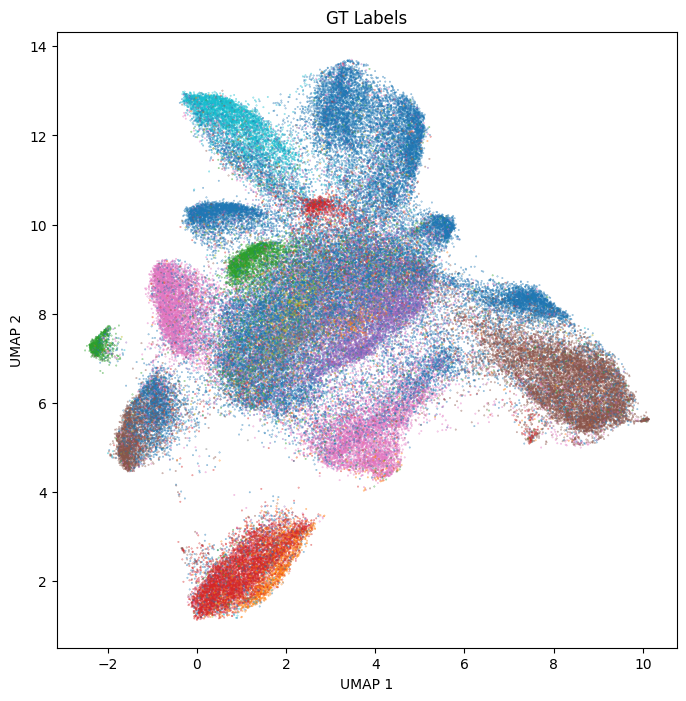

In [ ]:
unique_dates = np.unique(all_labels_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

# 将 sample_date 映射为颜色列表
colors = [color_map[date] for date in all_labels_subset]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('GT Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

Text(0, 0.5, 'UMAP 2')

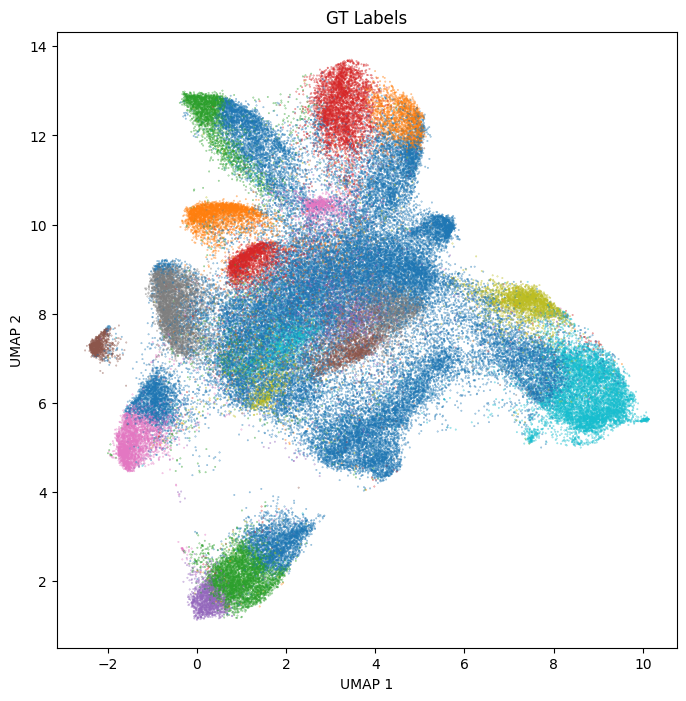

In [ ]:
unique_dates = np.unique(all_predictions_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in all_predictions_subset]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('GT Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

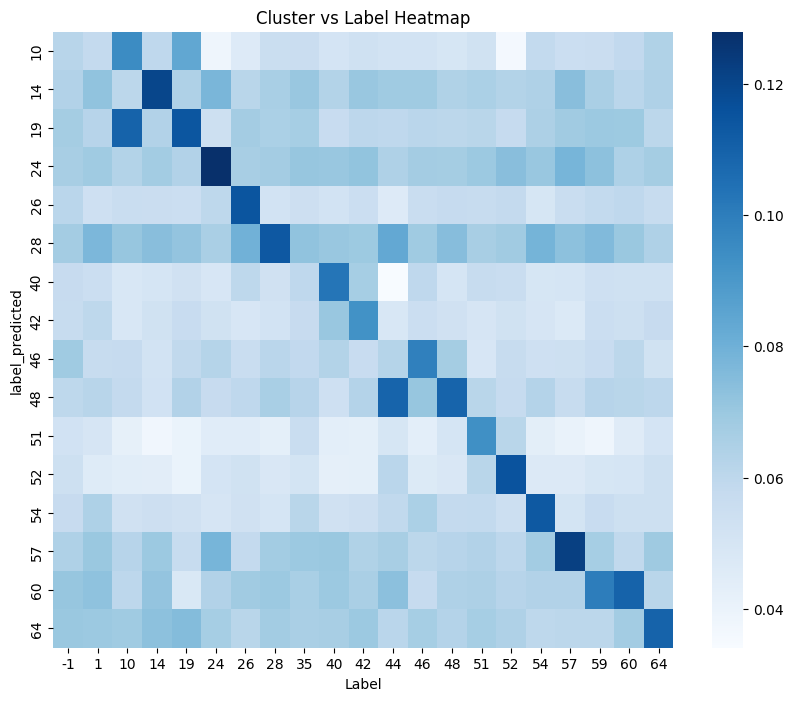

In [ ]:
heatmap_data = potent_spike_inf_subset.groupby(['label', 'label_predicted']).size().unstack(fill_value=0)
heatmap_data = np.log10(heatmap_data)
heatmap_data[heatmap_data == 0] = 1e-4
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_normalized, annot=False, cmap='Blues')
plt.xlabel('Label')
plt.ylabel('label_predicted')
plt.title('Cluster vs Label Heatmap')
plt.show()